# Minha primeira rede neural

Neste projeto, ire apresentar como construi minha primeira rede neiral para prever o uso diário do aluguel debicicletas

In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Carreando e preparando os dados

Uma etapa importante para trabalhar com redes neurais é preparar os dados coretamente. Variáveis em escalas diferentes tornam difícil para a rede neural aprender com eficiência os pesos corretos.

In [17]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [18]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checando os dados

Este conjunto de dados tem o número de ciclistas para cada hora de cada dia, de 1 de janeiro de 2011 a 31 de dezembro de 2012. O número de ciclistas é dividido entre casual e registrado, resumido na coluna `cnt`. As primeiras linhas dos dados podem ser vistas acima.

Abaixo está um gráfico mostrando o número de ciclistas nos primeiros 10 dias ou mais no conjunto de dados.(Alguns dias não têm exatamente 24 entradas no conjunto de dados, portanto, não são exatamente 10 dias.) As locações por hora podem ser vistas aqui. Esses dados são bem complicados! Os fins de semana diminuem em relação a todos os ciclistas e há picos quando as pessoas andam de bicicleta para o trabalho durante a semana. Observando os dados acima, também temos informações sobre temperatura, umidade e velocidade do vento, todas elas provavelmente afetando o número de ciclistas.


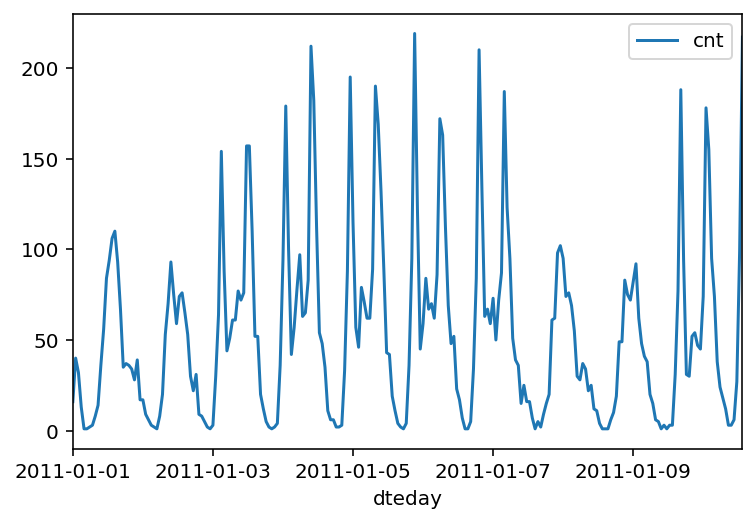

In [19]:
rides[:24*10].plot(x='dteday', y='cnt')

### Variáveis categóricas

Aqui temos algumas variáveis categóricas como estação, clima, mês. Para incluí-las no modelo, é necessário criar variáveis fictícias binárias. Isso é simples de fazer com o Pandas, graças a `get_dummies ()`.

In [20]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


# Escalando variáveis de destino

Para facilitar o treinamento da rede neural, variáveis contínuas são padronizadas. Ou seja, as variáveis são mudadas e escalonadas para que elas tenham média zero e um desvio padrão de 1.

Os fatores de escala são salvos para que possa retroceder quando a rede neural for usada para previsões.

In [21]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Armazena as variáveis escalonadas em dicionário para converter de volta mais tarde
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Dividindo os dados em conjuntos de treinamento, teste e validação

Os dados nos últimos 21 dias são salvos para serem usados como um conjunto de testes depois que a rede neural for treinada. Esse conjunto será usado para fazer previsões e compará-las com o número real de ciclistas.

In [22]:
# Salva os dados dos ultimos 21 dias aproximadamente
test_data = data[-21*24:]
# Agora remove os dados de teste da coleção de dados 
data = data[:-21*24]
# Separa od dados em features e targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

Os dados são divididos em dois conjuntos, um para treinamento e outro para validação conforme a rede neural estiver sendo treinada. Como se trata de dados de séries temporais, a rede neural sera treinada com os dados históricos e testada para prever os dados futuros (o conjunto de validação).

In [23]:
# Retem os últimos 60 dias ou mais dos dados restantes como um conjunto de validação
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Montagem da rede neural


<img src="assets/neural_network.png" width=300px>


A rede possui duas camadas, uma camada oculta e uma camada de saída. A camada oculta usará a função sigmóid para ativações. A camada de saída possui apenas um nó e é usada para a regressão, a saída do nó é igual à entrada do nó. Ou seja, a função de ativação é 𝑓 (𝑥) = 𝑥. Uma função que recebe o sinal de entrada e gera um sinal de saída, mas leva em consideração o limite, é chamada de função de ativação. Todas as saídas de uma camada se tornam entradas para os neurônios na próxima camada. Esse processo é chamado *propagação direta*.

Os pesos são usados para propagar os sinais da camada de entrada para a saída em uma rede neural. Os pesos também são usados para propagar o erro de volta da saída para a rede para atualizar os pesos. Isso é chamado de *retropropagação*.

> **Dica:** A derivada da função de ativação ($f(x) = x$) é necessária para fazer a implementação da retropropagação. Se você não estiver familiarizado com cálculo, esta função e equivalente a equação $y = x$. Qual é a inclinação da equação? Qual a derivada de $f(x)$.

In [24]:
#############
# No arquivo my_answers.py, esta a rede neruaral
#############

from neural_network import NeuralNetwork

In [25]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Treinando a rede neural

Aqui são definidos os hiperparâmetros para a rede. A estratégia aqui é encontrar hiperparâmetros de forma que o erro no conjunto de treinamento seja baixo, mas que não ocorra overfitting (a rede ficar adaptada de mais aos dados de teste) dos dados. Se a rede for treinada por muito tempo ou possui muitos nós ocultos, ela pode se tornar excessivamente específica para o conjunto de treinamento e falhará em generalizar para o conjunto de validação. Ou seja, a perda no conjunto de validação começará a aumentar à medida que a perda do conjunto de treinamento diminuir.

O método conhecido como descida de gradiente estocástico (Stochastic Gradient Descent - SGD) também pode ser usado para treinar a rede. A idéia é que, para cada passo de treinamento, uma amostra aleatória é pega dos dados em vez de usar o conjunto de dados inteiro. São usados muitos mais passes de treinamento do que na descida normal do gradiente, mas cada passe é muito mais rápido. Isso acaba treinando a rede com mais eficiência.

### Escolher o número de iterações

Esse é o número de lotes de amostras dos dados de treinamento que são usados para treinar a rede. Quanto mais iterações forem usadas, melhor o modelo ajustará os dados. No entanto, esse processo pode ter retornos bastante reduzidos e pode desperdiçar recursos computacionais se forem usadas muitas iterações. O objetivo aqui é encontrar um número em que a rede tenha uma baixa perda de treinamento e a perda de validação seja mínima. O número ideal de iterações seria um nível que para logo após a perda da validação não estar mais diminuindo.

### Escolher a taxa de aprendizado

Isso dimensiona o tamanho das atualizações de peso. Se for muito grande, os pesos tendem a explodir e a rede falha ao ajustar os dados. Normalmente, uma boa opção para começar é 0,1; no entanto, se a taxa de aprendizagem for dividida efetivamente por n_records, é melhor começar com 1. Nos dois casos, se a rede tiver problemas para ajustar os dados, é aconselhável reduzir a taxa de aprendizado. Observe que, quanto menor a taxa de aprendizado, menores são as etapas nas atualizações de peso e mais tempo leva para a rede neural convergir.

### Escolher o número de nós ocultos

Em um modelo em que todos os pesos são otimizados, quanto mais nós ocultos ele tiver, mais precisas serão as previsões do modelo. (Um modelo totalmente otimizado pode ter pesos zero, afinal.) No entanto, quanto mais nós ocultos o modelo tiver, mais difícil será otimizar os pesos do modelo e mais provável será que pesos abaixo do ideal levem a sobreajuste (overfitting). Com o ajuste excessivo, o modelo memoriza os dados de treinamento em vez de aprender o verdadeiro padrão e não generaliza bem os dados não vistos.

In [26]:
import sys

#########################################################
# Insira os hiperparâmetros no arquivo myanswers.py
##########################################################
from neural_network import iterations, learning_rate, hidden_nodes, output_nodes

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Passe por um lote aleatório de 128 registros do conjunto de dados de treinamento
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Imprimindo o progresso do treinamento
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 0.1% ... Training loss: 0.982 ... Validation loss: 1.391

/home/tiago/anaconda3/envs/dlnd/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


Progress: 100.0% ... Training loss: 0.260 ... Validation loss: 0.438

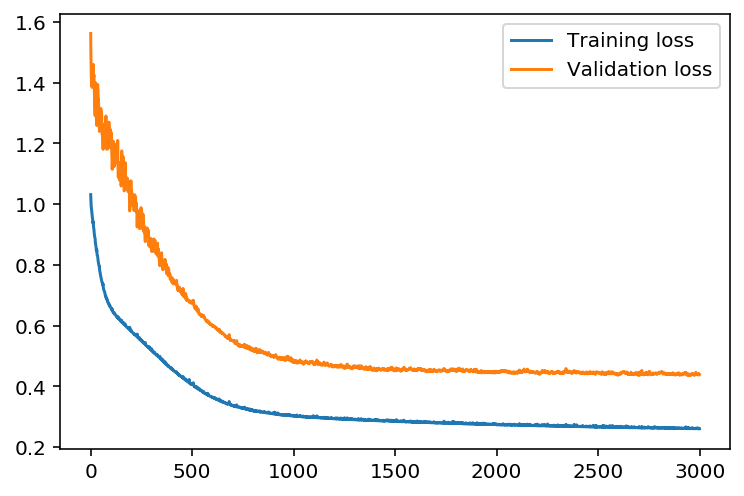

In [27]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Conferindo as previsões

Aqui, os dados de teste são usados para ver quão bem a rede neural está modelando os dados.

/home/tiago/anaconda3/envs/dlnd/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


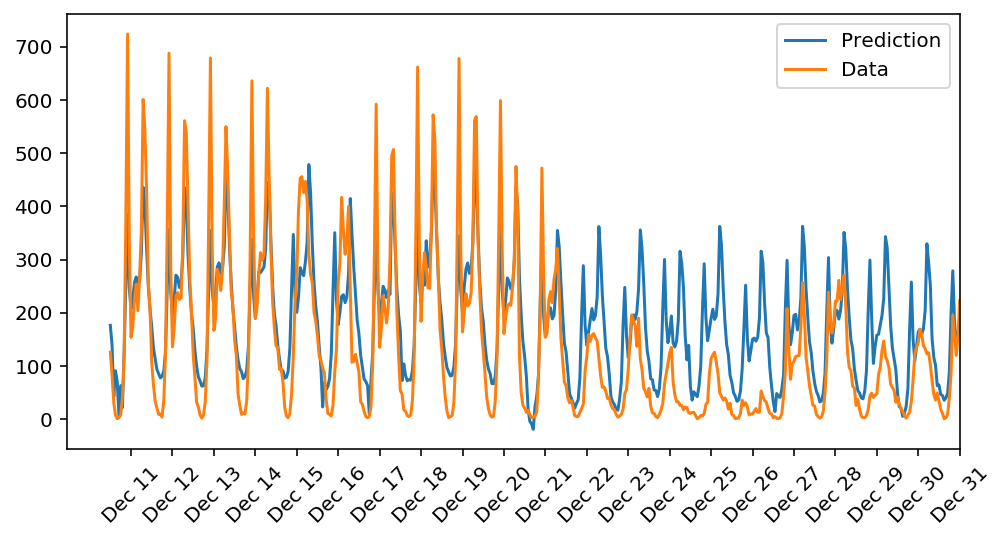

In [28]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)